# Auxilliary Tutorial 2: Kernel Density Estimation
*This tutorial was prepared by Muir Morrison and was generated from an Jupyter notebook.  You can download the notebook [here](r3_kde.ipynb).*

In [17]:
import warnings

# Our numerical workhorses
import numpy as np
import pandas as pd
import scipy.stats as st
import scipy.integrate

# Import pyplot for plotting
import matplotlib.pyplot as plt

# Seaborn, useful for graphics
import seaborn as sns

# MCMCHammer!
import emcee

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables high resolution PNGs. SVG is preferred, but has problems
# rendering vertical and horizontal lines
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)

# Suppress future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In this tutorial, we will learn about a powerful technique known as _kernel density estimation_, or KDE. KDE is a powerful non-parametric technique, in contrast to the largely parametric approach in most of this course.

## Developing intuition for KDE

Consider the probability mass function (PMF) for a discrete distribution, e.g., the binomial. We usually visualize the PMF as a histogram. The height of each bar indicates the probability of the corresponding (discrete) value.

For continuous variables, histograms are also commonly used. What are they really indicating? Well, each bar still represents a probability, but now it is a probability of falling _in an interval_, rather than taking on a discrete value. This reflects the fact that continuous distributions have a probability _density_ function (PDF) rather than a PMF. Though rarely stated explicity, histograms are usually generated from data in an attempt to indicate the shape of the PDF. The PDF is the real quantity of interest.

KDE is an alternative procedure to obtain an estimate of the PDF of an unknown distribution, given data. Histograms can be biased and misleading, especially with small data sets. KDE avoids the biggest problems with histograms and directly gives us what we actually want: an estimate of the probability density from which the data came.

Let's dive in with an example using some real data.

In [2]:
# load all the data sets we will use
df_frog = pd.read_csv('../data/kleinteich_and_gorb/frog_tongue_adhesion.csv', 
                      comment='#')
df_finch = pd.read_csv('../data/grant_and_grant/grant_and_grant_2014.csv', 
                       comment='#')
df_es = pd.read_csv('../data/singer_et_al/singer_transcript_counts.csv', 
                    comment='#')

# first frog data. Look at header as a reminder!
df_frog.head()

,date,ID,trial number,impact force (mN),impact time (ms),impact force / body weight,adhesive force (mN),time frog pulls on target (ms),adhesive force / body weight,adhesive impulse (N-s),total contact area (mm2),contact area without mucus (mm2),contact area with mucus / contact area without mucus,contact pressure (Pa),adhesive strength (Pa)
0,2013_02_26,I,3,1205,46,1.95,-785,884,1.27,-0.290,387,70,0.82,3117,-2030
1,2013_02_26,I,4,2527,44,4.08,-983,248,1.59,-0.181,101,94,0.07,24923,-9695
2,2013_03_01,I,1,1745,34,2.82,-850,211,1.37,-0.157,83,79,0.05,21020,-10239
3,2013_03_01,I,2,1556,41,2.51,-455,1025,0.74,-0.170,330,158,0.52,4718,-1381
4,2013_03_01,I,3,493,36,0.80,-974,499,1.57,-0.423,245,216,0.12,2012,-3975


To illustrate the problems with binned histograms, let's plot the impact forces for one frog with a few different choices of binning.

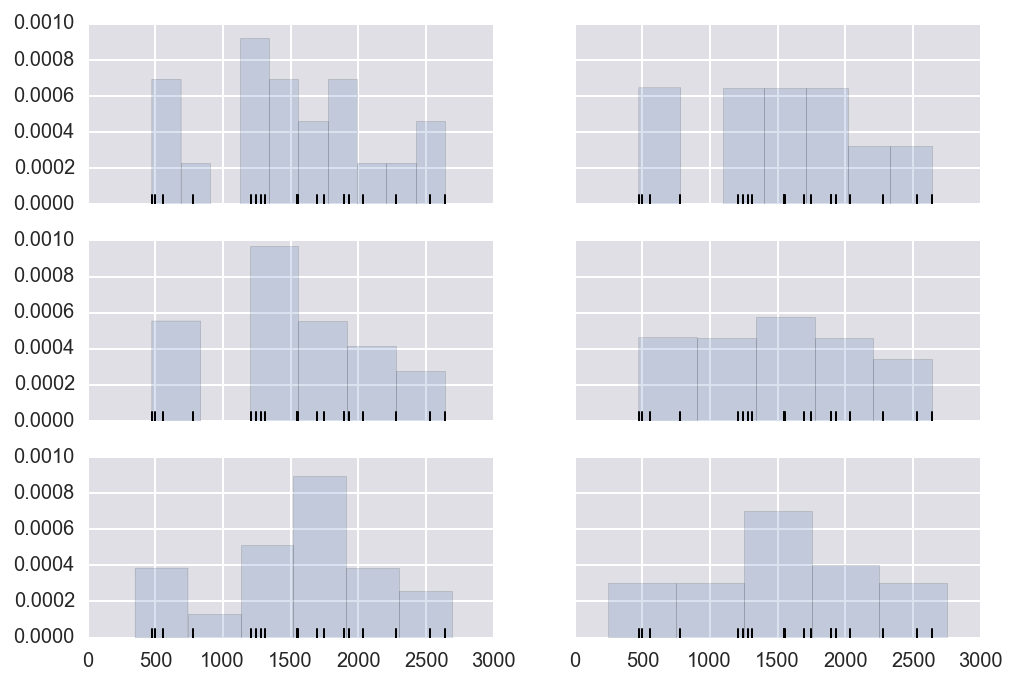

In [3]:
# Slice out impact forces for one frog
ID = df_frog['ID'] == 'I'
forces = df_frog['impact force (mN)'][ID]

# set up subplots
fig, ax = plt.subplots(3,2,sharex=True,sharey=True)
# plot the raw data on each subplot with seaborn's awesome rugplot
for i in (ax[0,0], ax[0,1], ax[1,0], ax[1,1], ax[2,0], ax[2,1]):
    _ = sns.rugplot(forces,ax=i)
    
# now demonstrate a variety of binning choices
_ = ax[0,0].hist(forces, normed=True, alpha=0.2)
_ = ax[0,1].hist(forces, bins = 7, normed=True, alpha=0.2)
_ = ax[1,0].hist(forces, bins = 6, normed=True, alpha=0.2)
_ = ax[1,1].hist(forces, bins = 5, normed=True, alpha=0.2)
_ = ax[2,0].hist(forces, bins = range(350,3000,390), normed=True, alpha=0.2)
_ = ax[2,1].hist(forces, bins = range(250,3200,500), normed=True, alpha=0.2)

Depending how we bin, our impression of the underlying distribution is completely different! Notice especially in the last two rows that, even with the same number of bins but different edge and width choices, the appearance of the distribution is radically different.

This illustrates 3 undesirable properties of binned histograms:

1) not smooth

2) depend on how edges of bins are chosen

3) depend on how widths of bins are chosen

Put another way, by binning, we add error unnecessarily: we're throwing away information about where each data point actually lies and simply lumping neighbors together. This was perfectly justifiable in the days before powerful computers, but now there is a better way: KDE.

To introduce the idea of KDE, let's imagine fixing the above problems one at a time. First let's fix 2). Suppose we have $n$ data points. Rather than binning, we could just draw a rectangle centered at each data point. This is the _kernel_ in KDE. Then at each point along the axis, the PDF is proportional to the sum of the kernels:

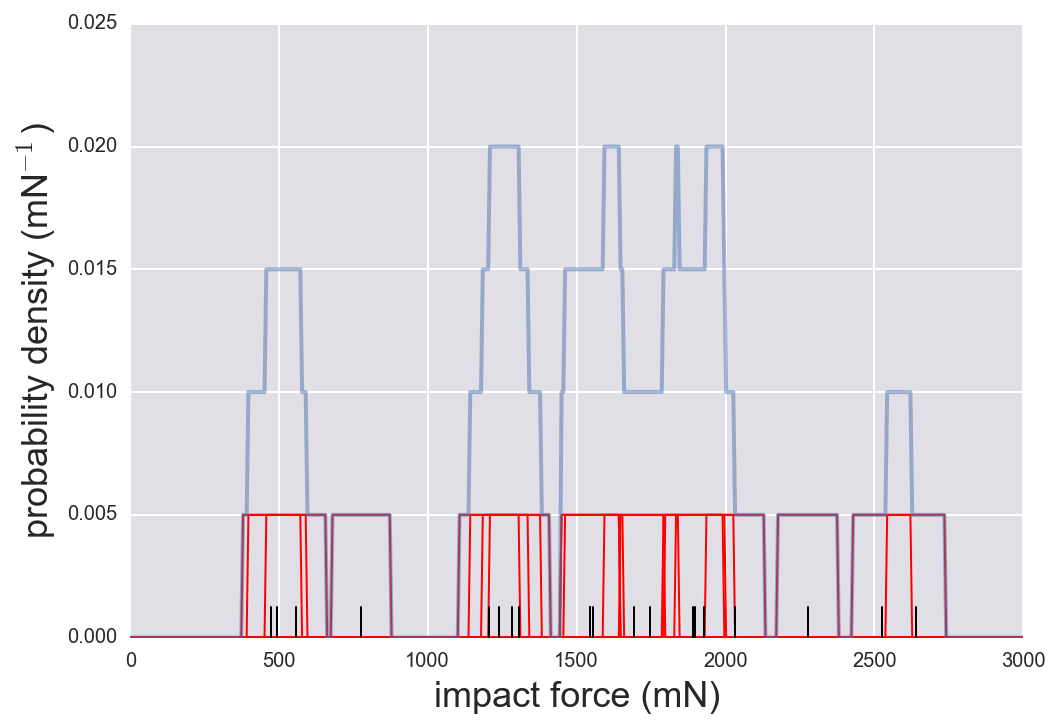

In [9]:
grid = np.linspace(0, 3000, 500)

# an array to collect the kernels from each data point
kernels = []

# bandwidth sets the half-width of the kernel
bandwidth = 100

# loop over the data points
for x_i in forces:
    # put a rectangle over each data point. Looking ahead,
    # the call to scipy.stats generalizes easily to other kernels
    kernel = st.uniform.pdf(grid, loc=x_i-bandwidth, scale=2*bandwidth)
    
    # add to the collection of kernels
    kernels.append(kernel)
    
    # plot the current kernel from this iteration of the loop
    plt.plot(grid, kernel, lw=1, color="r")
    
# kernels is an array of arrays. Sum across the kernels, not down.
# Note density is NOT normalized yet
density = np.sum(kernels, axis=0)
plt.plot(grid, density, lw=2, alpha=0.5)

# raw data 
_ = sns.rugplot(forces)
_ = plt.xlabel('impact force (mN)')
_ = plt.ylabel('probability density (mN$^{-1}$)')

That fixes the edge bias problem, but we usually expect the real PDF to be a smooth function. We can remove the jaggedness by using a smooth function for the kernel. One common choice is a Gaussian. Again, we place a copy of the kernel centered on each data point, then add them up to construct the PDF:

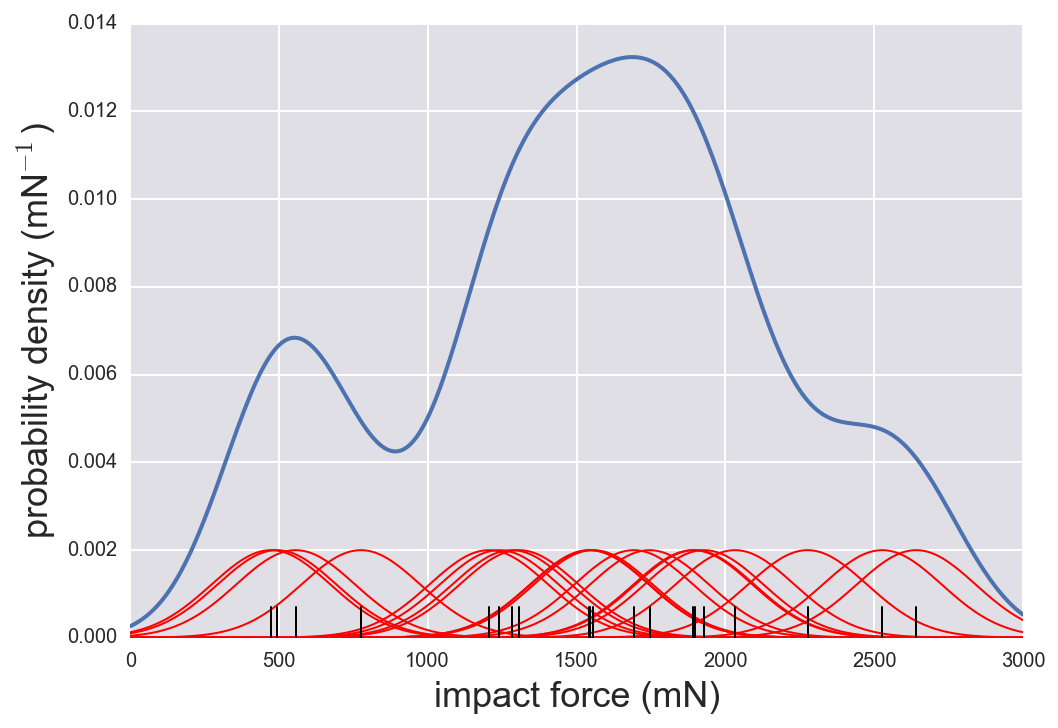

In [10]:
grid = np.linspace(0, 3000, 300)
kernels = []

# now bandwidth is the std dev of Gaussian kernels
bandwidth = 200

for x_i in forces:
    # place kernel on data point
    kernel = st.norm(x_i, bandwidth).pdf(grid)
    
    # add to the list
    kernels.append(kernel)
    
    # plot it
    plt.plot(grid, kernel, lw=1, color="r")

# add up kernels
density = np.sum(kernels, axis=0)
plt.plot(grid, density, lw=2)
# raw data 
_ = sns.rugplot(forces)
_ = plt.xlabel('impact force (mN)')
_ = plt.ylabel('probability density (mN$^{-1}$)')

To finish the job, the PDF must be normalized:

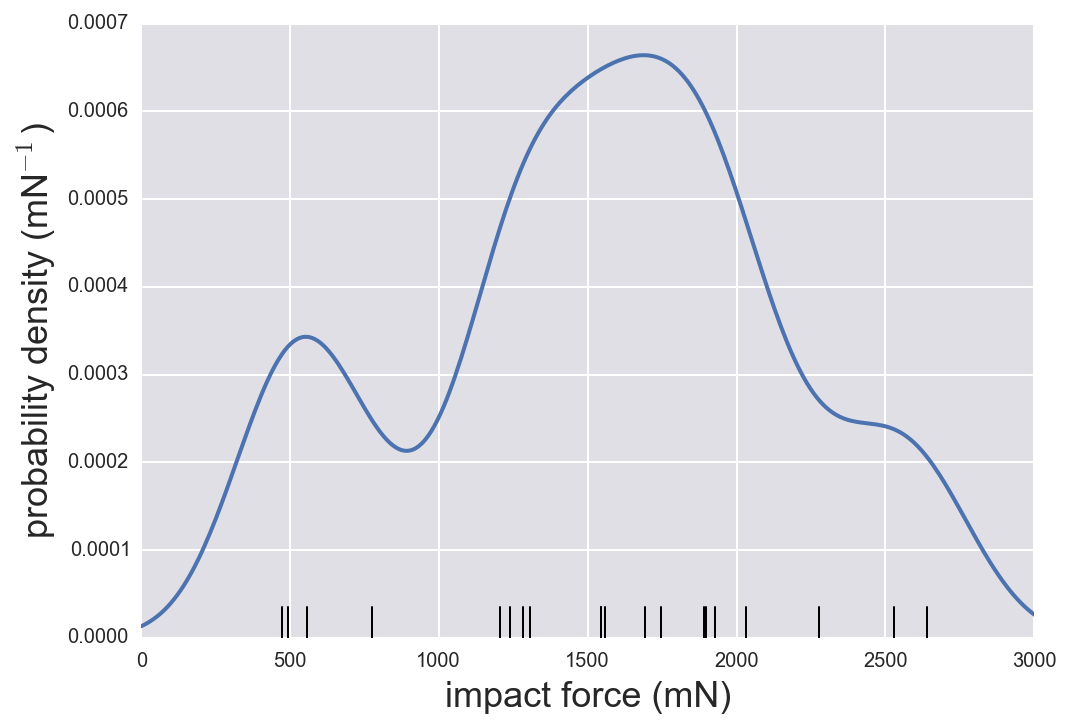

In [11]:
# integrate the density over full range and divide by the result
density /= scipy.integrate.trapz(density, grid)
plt.plot(grid, density)
_ = sns.rugplot(forces)
_ = plt.xlabel('impact force (mN)')
_ = plt.ylabel('probability density (mN$^{-1}$)')

Conceptually, that's all there is to it! KDE neatly solves 2 of the 3 problems with histograms we mentioned previously: it eliminates bin edge bias and it automatically returns a smooth estimate of the PDF if we use a smooth kernel.

Note that we wrote our own KDE function from scratch just to illustrate how it works. It shouldn't surprise you that there are implementations of KDE in many of the packages we're already familiar with, and in the real world they will vastly outperform the function we wrote ourselves. `scipy.stats` has an implementation of KDE with a Gaussian kernel, and Seaborn has a very nice implementation with a choice of several kernels (Gaussian, cosine, Epanechnikov, and more). These should be sufficient for most of your needs. If you have very large datasets, you might want to consider `scikit-learn`'s implementation; it is very fast and powerful, but correspondingly more complex for the user. Check their documentation for more details. We will demonstrate `scipy.stats` and Seaborn's implementations below.

## Bandwidth Selection

Continuing on, while KDE easily solves 2 of the 3 problems with histograms, it does not automatically remove the problem of bin width/bandwidth, and if this doesn't bother you, here's why it should:

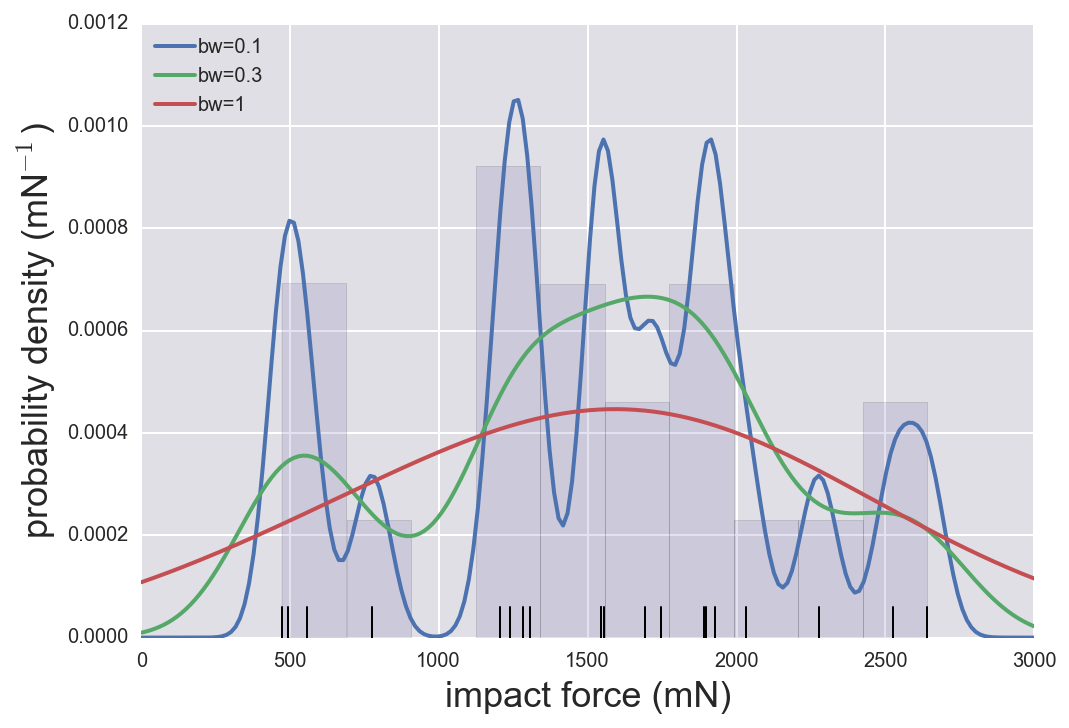

In [12]:
grid = np.linspace(0,3000,200)

fig, ax = plt.subplots()

# plot the raw data
_ = sns.rugplot(forces)

# loop over several example bandwidths
for bandwidth in [0.1,0.3,1]:
    # calculate the kde
    kde = st.gaussian_kde(forces,bw_method=bandwidth)

    # evaluate the precomputed kde for plotting on our grid
    ax.plot(grid, kde.evaluate(grid), label='bw={0}'.format(bandwidth))

# a histogram for comparison
_ = ax.hist(forces, alpha=0.2, normed=True)

# Tidy up plot
ax.legend(loc='upper left')
_ = plt.xlabel('impact force (mN)')
_ = plt.ylabel('probability density (mN$^{-1}$)')

The over- and undersmoothing is obvious in two of the above traces and, intuitively, is not giving us a remotely good estimate of the true distribution. By eye, the middle choice of bandwidth looks like a reasonable guess at the true distribution, but how are we to know? It would be nice to have a more concrete criteria for bandwidth selection than "that looks about right."

To proceed, we need to formalize our intuitive understanding. The definition of the KDE estimate for one-dimensional data is

\begin{equation}
f_h(x) = \frac{1}{nh}\sum_{i=1}^n K\left(\frac{x - x_i}{h}\right), 
\end{equation}

where $x$ is the variable of interest, the $x_i$ are the data points, $f_h$ is the estimate of the PDF, $n$ is the number of data points, and $K$ is the kernel function. The kernel is assumed to be a normalized probability density with bandwidth controlled by the parameter $h$, so the factor of $1/n$ ensures $f_h$ is normalized. This equation mathematizes the intuitive cartoon from above: we put a kernel around each data point, add up the contribution from all data points, and normalize the resulting function to obtain an estimate of the PDF.

The goal is to minimize the error between our estimate of the distribution and the true distribution. There are many possible methods and criteria for doing this, but the standard choice is to minimize the mean integrated squared error (MISE),

\begin{equation}
E\left( \int (f_h(x) - f(x))^2 \ dx \right).
\end{equation}

But this requires knowledge of $f$, the unknown PDF we're trying to obtain! Thus this formula is not directly very useful. From here, most approaches go one of two ways: 1) make assumptions about $f$ and proceed analytically, or 2) use machine learning techniques to choose bandwidth.

If one is willing to make assumptions about the form of $f$, then the MISE formula above can be used. For instance, if one uses Gaussian kernels *and* assumes the underlying distribution is Gaussian, then the optimal bandwidth is given by the following rule of thumb (variously attributed to Scott or Silverman and sometimes bearing either of their names),

\begin{equation}
h \approx 1.06 \sigma n^{-1/5},
\end{equation}

where $\sigma$ is the standard deviation of the data samples and $n$ is the number of data points. Similar expressions can be derived for other kernels and other assumed forms of $f$. For exploratory data analysis, such rules are good starting points and, with luck, might even be close to the correct bandwidth. But as we emphasize repeatedly in this course, we must be careful and explicit with the assumptions we make. In my opinion, publication-quality analysis should undergo more rigorous testing, especially since KDE is often used for the very reason that the data distribution is not known _a priori_!

To avoid making unwarranted assumptions about $f$, machine learning ideas are often used to select an optimal bandwidth, usually under the umbrella of cross-validation techniques. Roughly, the idea is to partition data into training and validation sets, generate a kernel density estimate from the training set for many choices of bandwidth, and use the choice that best predicts the validation set. This is repeated many times for different partitions of the data. Though useful, these ideas are well beyond the scope of this course so we will not pursue them here.

## KDE with smFISH dataset

Instead, let's move on to another example and look at the smFISH data from last week's tutorial. As a reminder, this data set comprises counts of mRNA transcripts of 4 genes in embryonic stem cells.

In [13]:
df_es.head()

,Rex1,Rest,Nanog,Prdm14
0,11,34,39,0
1,172,91,33,5
2,261,70,68,0
3,178,54,88,1
4,129,54,41,0


Let's use Seaborn's fantastic KDE one-liner! We can also use it to compare the difference between using a Gaussian kernel and an Epanechnikov kernel. The Epanechnikov kernel is given by

\begin{equation}
K(u) = \frac{3}{4} \left( 1 - u^2 \right)
\end{equation}

where the argument $u = \left(\frac{x - x_i}{h}\right)$, the distance between $x$ and the data point $x_i$ scaled by the bandwidth $h$. The Epanechnikov kernel is commonly used because it is "optimal" in the sense of minimizing MISE. But recall that, though it is standard, the MISE is merely one possible choice for minimizing error of our estimate, so there are no definitively right or wrong answers in the choice of kernel.

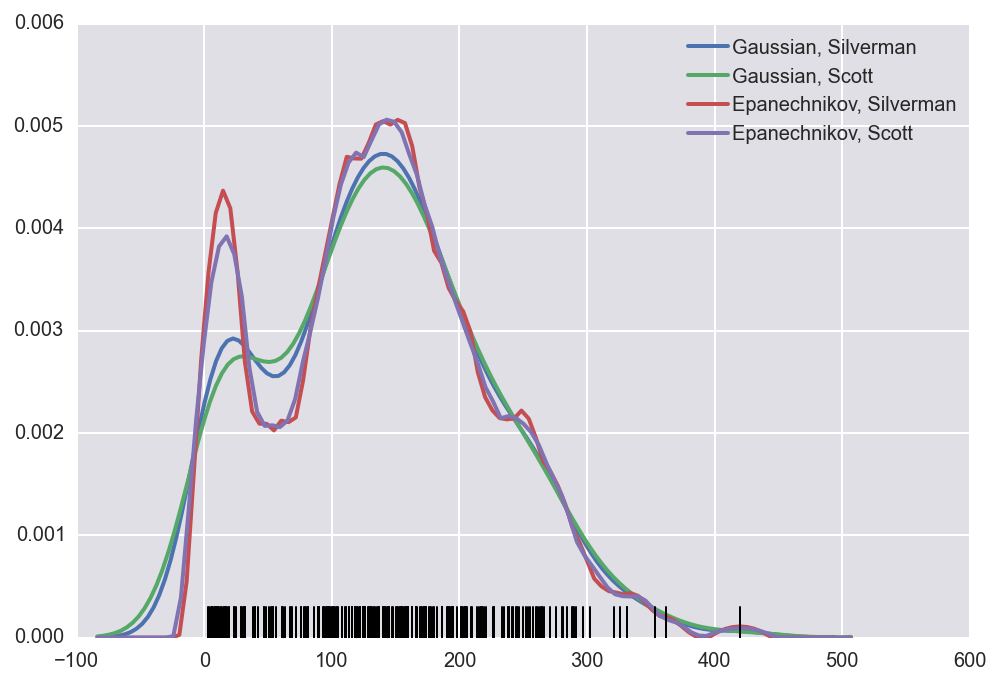

In [15]:
fig, ax = plt.subplots()
_ = sns.kdeplot(df_es.Rex1, kernel='gau', bw='Silverman',
                label='Gaussian, Silverman')
_ = sns.kdeplot(df_es.Rex1, kernel='gau', bw='Scott',
                label='Gaussian, Scott')
_ = sns.kdeplot(df_es.Rex1, kernel='epa', bw='Silverman',
                label='Epanechnikov, Silverman')
_ = sns.kdeplot(df_es.Rex1, kernel='epa', bw='Scott',
                label='Epanechnikov, Scott')
_ = sns.rugplot(df_es.Rex1)

Seaborn has a variety of built-in methods for choosing bandwidth which can be applied to the several available kernels. We show a few above to give a flavor, but as always, the documentation has more info on the many choices available. It is interesting to note the qualitative difference between the Gaussian and Epanechnikov kernels with automatic bandwidth chosen. Note that both have probability density spilling into the physically impossible range below zero. This might bother you, but the KDE algorithm has no knowledge of such bounds. Curiously, there is no standard agreement on the proper way to handle hard bounds in KDE; should the KDE be done as normal and the final PDF truncated after the fact, or should the kernels themselves be changed near the boundary? The answer is not obvious. `scipy.stats` has work in the pipeline that may address this, so stay tuned for future developments.

## Violin plots

Now that we've seen how Seaborn handles basic KDE plots, let's see another common data visualization known as _violin plots_. This takes the form of a box plot along the centerline with a KDE estimate alongside. Violin plots are often used to visualize the difference between several similar but distinct distributions. Seaborn's interface allows us to simply drop in a tidy DataFrame and it takes care of the rest. Once again, tidy data rules!

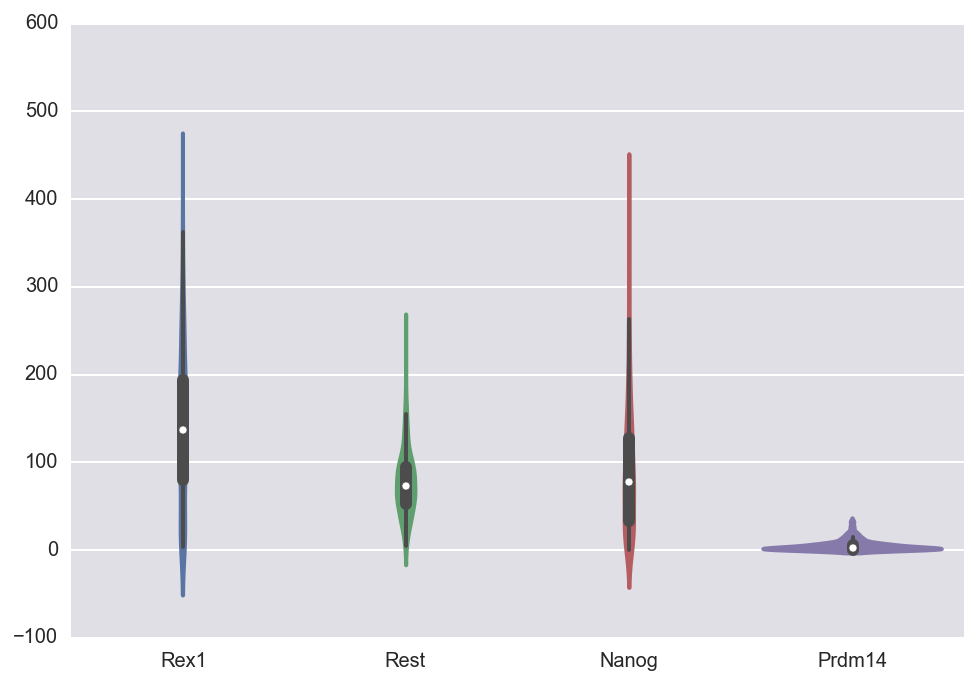

In [19]:
_ = sns.violinplot(data=df_es)

The enormous number of zero values in the Prdm14 data renders its KDE estimate somewhat suspect. It is also skewing the axes for the rest of the plots. We'll use two of `violinplot`'s many available methods to present the data in a more useful way:

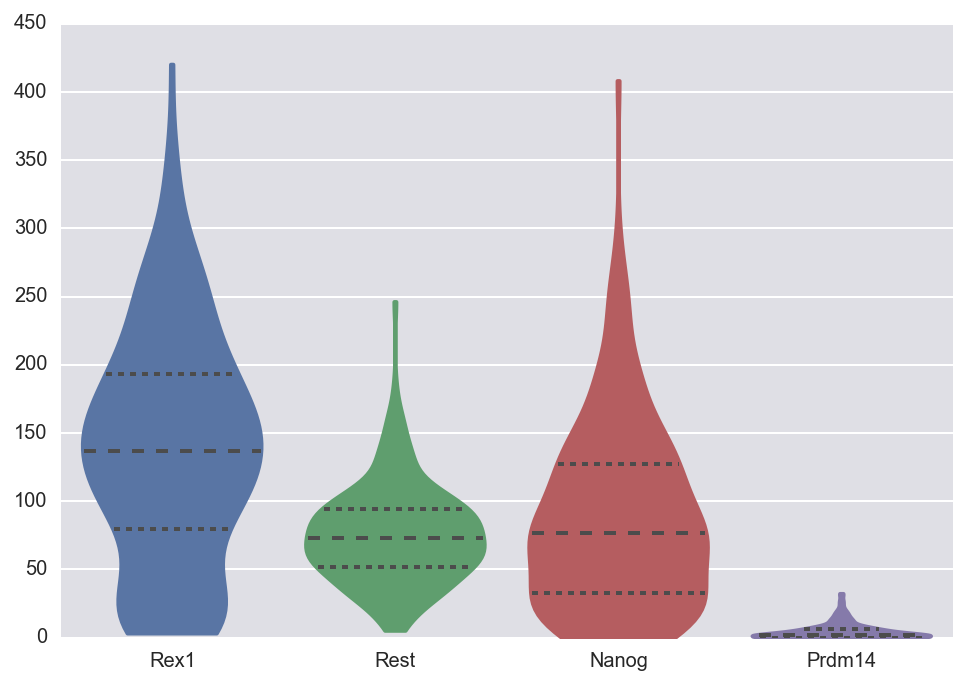

In [21]:
# df_es_sliced = df_es.drop('Prdm14', axis=1)
# cut=0 forces the KDE to not be drawn past the extreme data points,
# scale='width' sets all KDE's to have the same width
# inner changes how the raw data is presented or summarized

_ = sns.violinplot(data=df_es, cut=0, scale='width', inner='quartile')

This is but a small sampling of the many options available in `violinplots` to present data; as always, check the documentation for more.

## Two-dimensional KDE using finch data set

So far we have only done KDE on one-dimensional data, but the algorithm generalizes easily to higher dimensions. Let's see how the 2D version works with the Galapagos finch data from Homework 1. First we'll use the implementation from `scipy.stats`, which only has a Gaussian KDE available. 

In [22]:
df_finch.head()

,Mid-offspr,Male BD,Female BD
0,10.70,10.90,9.3
1,9.78,10.70,8.4
2,9.48,10.70,8.1
3,9.60,10.70,9.8
4,10.27,9.85,10.4


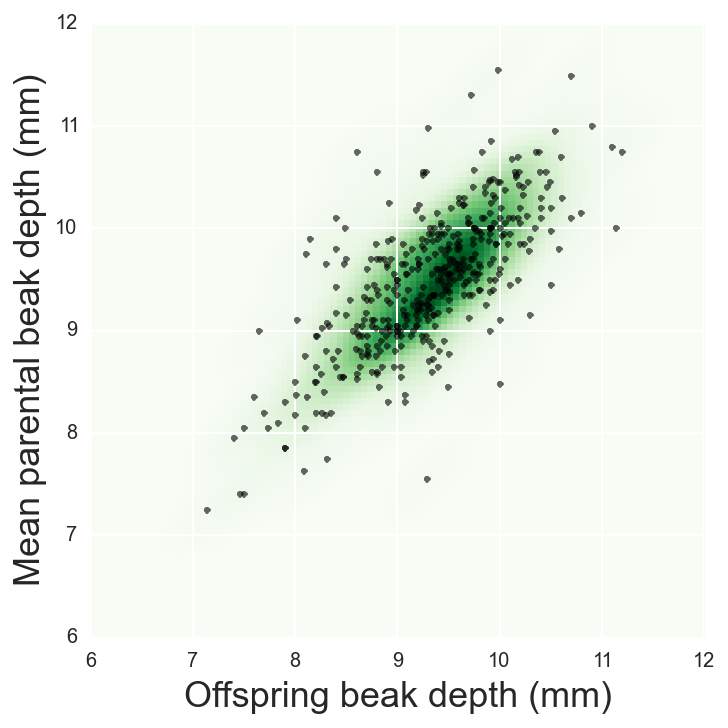

In [24]:
# calculate mean beak depth of two parents
mean_parent_BD = ( df_finch['Female BD'] + df_finch['Male BD'] ) / 2.

# set up grids. Borrowed from scipy.stats.gaussian_kde documentation.
X, Y = np.mgrid[6:12:100j, 6:12:100j]
positions = np.vstack([X.ravel(), Y.ravel()])
values = np.vstack([df_finch['Mid-offspr'], mean_parent_BD])
kernel = st.gaussian_kde(values)
Z = np.reshape(kernel(positions).T, X.shape)

fig, ax = plt.subplots()
_ = ax.plot(df_finch['Mid-offspr'], mean_parent_BD,'k.', alpha=0.6)
_ = ax.imshow(np.rot90(Z), extent=[6, 12, 6, 12], cmap='Greens')
_ = plt.xlabel('Offspring beak depth (mm)')
_ = plt.ylabel('Mean parental beak depth (mm)')

Instead of a heatmap, we could present the estimate as a contour plot. Let's demonstrate Seaborn's interface, and rather than averaging parental beak depths, let's simply plot offspring vs. their mothers. Note that for 2D data, Seaborn can only use a Gaussian kernel.

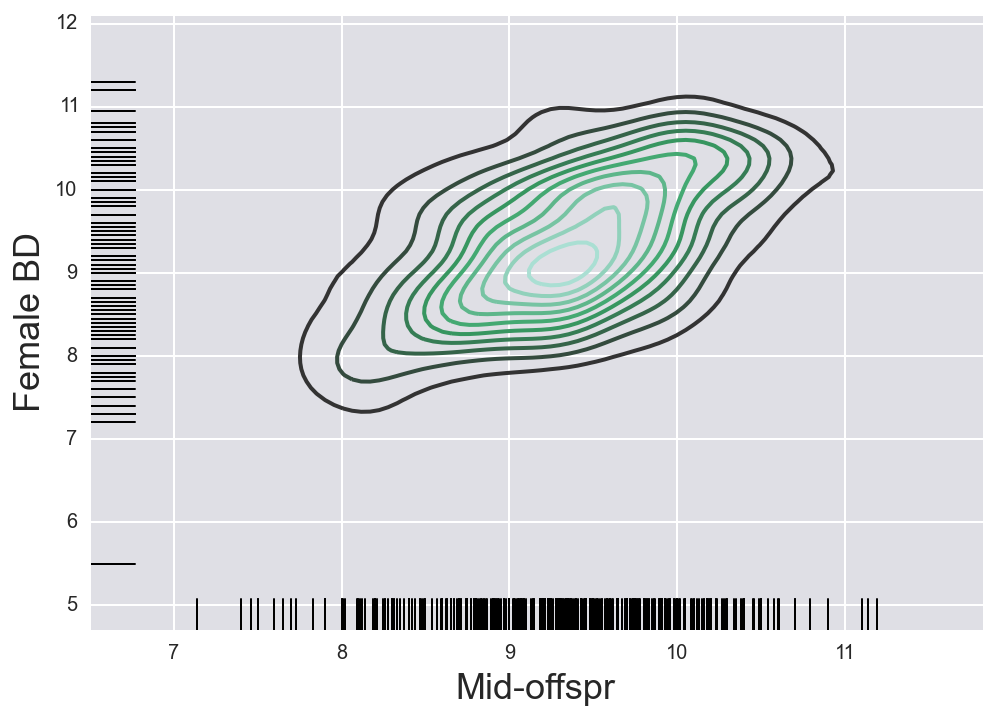

In [25]:
fig, ax = plt.subplots()
_ = sns.kdeplot(df_finch['Mid-offspr'],
                  df_finch['Female BD'],kind='kde', ax=ax)
_ = sns.rugplot(df_finch['Mid-offspr'], ax=ax)
_ = sns.rugplot(df_finch['Female BD'],vertical=True, ax=ax)

In principle, KDE can be done on higher dimensional data, but in practice this is not often done. Partly this is simply because presenting and visualizing the result becomes very difficult, but also because higher dimensions bring new subtleties. The bandwidth is no longer a single parameter; the kernel is now characterized by a bandwidth _matrix_ (e.g., one could imagine an asymmetric kernel for the finch data above). Not surprisingly, choosing these matrix elements can rapidly become an intractable problem as dimensionality increases. Algorithms vaguely similar in spirit to KDE are sometimes used in high-dimensional machine learning problems but usually go by different names. Again, all this is well beyond the scope of this course.

## KDE for MCMC results

Finally, KDE can also be used to visualize the posterior generated from MCMC calculations.  In principle, this is really no different from experimental data; we have samples that are from some unknown distribution, and we want to infer the shape of the distribution.

There is one potential wrinkle that might bother you: the samples from MCMC are correlated. The walkers are wandering through parameter space, and a walker's next step depends on its present location, so successive samples are clearly not independent like we've assumed in the previous examples of KDE on raw data.

In practice we needn't worry because this same problem exists for MCMC generally, and the solution is to run long enough chains that the walkers fully explore the posterior and "forget" their travels. In other words, if the sampling is good enough to confidently make statements about the posterior distribution, it's good enough to do KDE on said distribution.

We'll use the smFISH data again; the MCMC code is exactly what we used in lab.

In [26]:
# log posterior from tutorial 4b
def log_posterior(params, n):
    """
    Log posterior for MLE of Singer data.
    """
    r, p = params
    
    # Zero probability of having p < 0 or p > 1
    if p < 0 or p > 1:
        return -np.inf
    
    # Zero probability of r < 0
    if r < 0:
        return -np.inf

    return st.nbinom.logpmf(n, r, p).sum()

In [27]:
# set up parameters for MCMC. From tutorial 4b

n_dim = 2        # number of parameters in the model (r and p)
n_walkers = 50   # number of MCMC walkers
n_burn = 500     # "burn-in" period to let chains stabilize
n_steps = 500   # number of MCMC steps to take after burn-in
np.random.seed(42)

# p0[i,j] is the starting point for walker i along variable j.
p0 = np.empty((n_walkers, n_dim))
p0[:,0] = np.random.exponential(0.1, n_walkers)          # r
p0[:,1] = np.random.uniform(0, 1, n_walkers)             # p

In [28]:
# instantiate sampler
sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_posterior, 
                                args=(df_es['Prdm14'],), threads=6)

In [29]:
# Do burn-in
pos, prob, state = sampler.run_mcmc(p0, n_burn, storechain=False)

In [30]:
# Sample again, starting from end burn-in state
_ = sampler.run_mcmc(pos, n_steps)

Seaborn has a great built-in for 2D distributions called `jointplot`: it can do 2D KDE with a one-liner, also plotting KDE's for the marginalized variables too! With 25,000 samples it may take a few seconds to run. As mentioned before, if you're working with very large datasets, you might want to look into the implementation in scikit-learn.

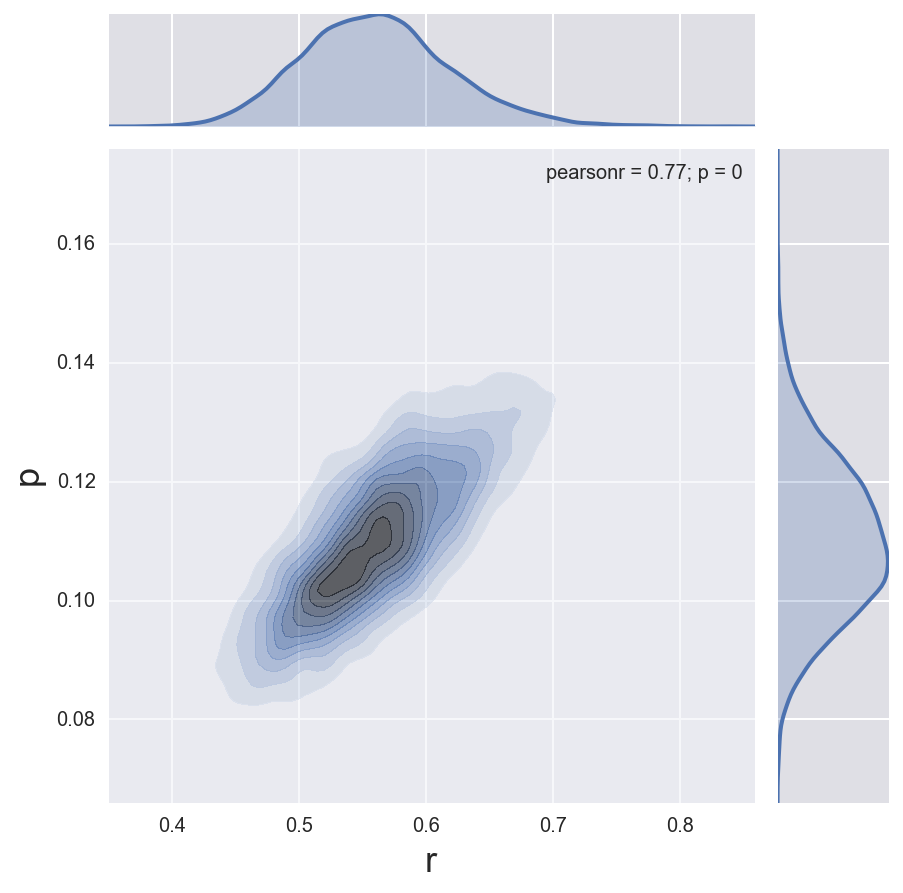

In [32]:
# feed jointplot x & y data, set kind kwarg to kde
_ =  sns.jointplot(x=sampler.flatchain[:,0],
                   y=sampler.flatchain[:,1],
                   kind='kde', alpha=0.6).set_axis_labels("r", "p")